### Project Introduction

In this machine learning project, we aim to predict the prices of used cars based on various features. The dataset contains information about used cars which was scrapped from cars24.com, including car Type, fuel used, number of previous owners, distance travelled and more. We'll use the CatBoostRegressor algorithm, known for efficiently handling categorical features and providing accurate predictions.

## 1. Library Imports

The code cell imports the following Python libraries and modules, which will be used later in the project:

- **pandas as pd**: For data manipulation and analysis using DataFrames.
- **numpy as np**: For numerical computations and array operations.
- **scipy.stats**: For statistical functions and probability distributions.
- **matplotlib.pyplot as plt**: For creating visualizations and plots.
- **seaborn as sns**: For enhanced data visualization with DataFrames.
- **catboost.Pool**, **CatBoostRegressor**: For CatBoost algorithm-based regression tasks.
- **sklearn.metrics**: For evaluation metrics like mean squared error and R-squared.
- **sklearn.model_selection**: For train-test data splitting and model selection.
- **feature_engine.encoding.RareLabelEncoder**: For handling rare categories in categorical features.
- **sklearn.feature_extraction.text.CountVectorizer**: For converting text data to numerical representations.
- **ast**: For abstract syntax tree manipulation (specific usage will be explained later).
- **shap**: For explaining machine learning models and feature contributions.

These libraries will enable us to effectively preprocess the data, create visualizations, train our regression model, and evaluate its performance. More detailed explanations of their usage will be provided in subsequent sections of the project.


In [75]:
!pip install ipywidgets

In [76]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import ast
import shap
import pickle

## 2. Data Preprocessing

In this section, we perform essential data preprocessing steps to ensure data quality and model readiness:

1. **Loading and Dropping Duplicates**:
   - The dataset is loaded from 'cars_24_combined.csv' using `pd.read_csv('cars_24_combined.csv', index_col=[0])`.
   - Duplicate rows are removed using the `drop_duplicates()` function to ensure data integrity.

2. **Handling Missing Values**:
   - We inspect the dataset for missing values using the `info()` function to identify any null entries in different columns.
   - For the 'Year', 'Location', and 'Car Name' columns, missing values are filled with the string 'None' to handle missing or unspecified data.

3. **Feature Engineering**:
   - We scale the 'Price' column to 'Price [Lakh INR]' by dividing all values by 1e5 to convert them into Lakh INR units.
   - To capture the relationship between 'Distance' and the target variable, we apply the log10-transformation to 'Distance' and group it into larger bins.

4. **Data Normalization and Type Conversion**:
   - We normalize the 'Distance' feature using the log10-transformation to handle its skewed distribution.
   - The 'Year' column is converted to a string data type to ensure consistency when working with categorical data.

5. **Data Cleaning**:
   - Missing values in 'Location' and 'Car Name' columns are filled with the string 'None' to handle incomplete information.
   - To ensure consistency in categorical data, the 'Car Name' column is converted to lowercase.

6. **Rare Category Handling with RareLabelEncoder**:
   - For categorical features like 'Car Name', 'Fuel', 'Location', and 'Drive', we use the `RareLabelEncoder` from the `feature_engine.encoding` module.
   - The `RareLabelEncoder` helps handle rare categories by combining them into a new category called 'Other'. This prevents overfitting and maintains model robustness.

The data is now preprocessed, ready for exploration, and suitable for building our machine learning model.



In [2]:
car_data = pd.read_csv('cars_24_combined.csv', index_col=[0])
print(car_data.shape)
car_data = car_data.drop_duplicates()
print(car_data.shape)
car_data.sample(5).T

(8015, 9)
(8015, 9)


,5268,700,88,2922,6234
Car Name,Maruti Baleno,Hyundai Grand i10,Mahindra XUV 3OO,KIA SONET,Maruti Swift
Year,2021.0,2014.0,2020.0,2020.0,2018.0
Distance,18885,36702,21270,12461,56130
Owner,1,1,1,1,2
Fuel,PETROL,PETROL,DIESEL,PETROL,PETROL
Location,HR-26,GJ-05,GJ-01,DL-10,TN-06
Drive,Manual,Manual,Automatic,Manual,Manual
Type,HatchBack,HatchBack,SUV,SUV,HatchBack
Price,709000,393000,1064000,1209000,555000


In [3]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8015 entries, 0 to 8014
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Car Name  8014 non-null   object 
 1   Year      8014 non-null   float64
 2   Distance  8015 non-null   int64  
 3   Owner     8015 non-null   int64  
 4   Fuel      8015 non-null   object 
 5   Location  7802 non-null   object 
 6   Drive     8015 non-null   object 
 7   Type      8015 non-null   object 
 8   Price     8015 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 626.2+ KB


In [4]:
car_data.describe()

,Year,Distance,Owner,Price
count,8014.000000,8015.000000,8015.000000,8.015000e+03
mean,2016.995009,52621.411728,1.300187,5.748829e+05
std,2.861454,29182.922728,0.510893,2.651049e+05
min,2010.000000,0.000000,1.000000,1.190000e+05
25%,2015.000000,30730.000000,1.000000,3.930000e+05
50%,2017.000000,50359.000000,1.000000,5.350000e+05
75%,2019.000000,71762.000000,2.000000,6.980000e+05
max,2023.000000,971212.000000,4.000000,3.300000e+06


In [5]:
missing_data = car_data.isnull()
missing_data.sample(10)

,Car Name,Year,Distance,Owner,Fuel,Location,Drive,Type,Price
1592,False,False,False,False,False,False,False,False,False
3512,False,False,False,False,False,False,False,False,False
4371,False,False,False,False,False,False,False,False,False
4052,False,False,False,False,False,False,False,False,False
7779,False,False,False,False,False,False,False,False,False
7736,False,False,False,False,False,False,False,False,False
7468,False,False,False,False,False,False,False,False,False
2460,False,False,False,False,False,False,False,False,False
1744,False,False,False,False,False,False,False,False,False
6084,False,False,False,False,False,False,False,False,False


In [6]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

Car Name
Car Name
False    8014
True        1
Name: count, dtype: int64

Year
Year
False    8014
True        1
Name: count, dtype: int64

Distance
Distance
False    8015
Name: count, dtype: int64

Owner
Owner
False    8015
Name: count, dtype: int64

Fuel
Fuel
False    8015
Name: count, dtype: int64

Location
Location
False    7802
True      213
Name: count, dtype: int64

Drive
Drive
False    8015
Name: count, dtype: int64

Type
Type
False    8015
Name: count, dtype: int64

Price
Price
False    8015
Name: count, dtype: int64



In [7]:
car_data.dropna(subset=["Year"], axis=0, inplace=True)
car_data.reset_index(drop=True, inplace=True)
car_data.shape


(8014, 9)

In [8]:
main_label = 'Price [Lakh INR]'
car_data[main_label] = car_data['Price']*1e-5
# log10-transform distance and group for larger bins
car_data['log10_Distance'] = car_data['Distance'].apply(lambda x: 1/5*round(5*np.log10(1+x)))
# convert years to string
car_data['Year'] = car_data['Year'].fillna('None').astype(str)
# fill NaN values
car_data['Location'] = car_data['Location'].fillna('None')
car_data['Car Name'] = car_data['Car Name'].fillna('None')
# lowercase car names
car_data['Car Name'] = car_data['Car Name'].str.lower()


In [9]:
# fill NaN values
car_data['Location'] = car_data['Location'].fillna('None')
car_data['Car Name'] = car_data['Car Name'].fillna('None')
# lowercase car names
car_data['Car Name'] = car_data['Car Name'].str.lower()

In [10]:
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['Car Name', 'Fuel', 'Location', 'Drive', 'Drive']:
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=60, replace_with='Other', tol=20/car_data.shape[0])
    car_data[col] = encoder.fit_transform(car_data[[col]])
# drop unused columns
cols2drop = ['Price', 'Distance']
car_data = car_data.drop(cols2drop, axis=1)
print(car_data.shape)
car_data.sample(5)

(8014, 9)


,Car Name,Year,Owner,Fuel,Location,Drive,Type,Price [Lakh INR],log10_Distance
4279,maruti swift,2010.0,2,PETROL,MH-02,Manual,HatchBack,2.45,4.8
364,renault kwid,2020.0,2,PETROL,KA-51,Automatic,HatchBack,5.60,4.0
2987,Other,2016.0,2,DIESEL,GJ-27,Manual,SUV,6.11,4.8
3842,maruti wagon r 1.0,2017.0,1,PETROL,MH-05,Manual,HatchBack,3.87,4.4
3536,honda amaze,2014.0,3,PETROL,KA-04,Manual,Sedan,4.00,4.8


## 3. Exploratory Data Analysis (EDA)

In this section, we conduct Exploratory Data Analysis (EDA) to gain insights into the relationships between various features and the target variable 'Price'. We use various visualizations and statistical methods to understand the data distribution and uncover potential patterns. Below are the key components of our EDA:

1. **Data Visualizations and Analysis**:
   - Scatter Plot: We create a scatter plot to visualize the relationship between the log10-transformed 'Distance' and 'Price'. This allows us to observe any linear or nonlinear patterns between these two variables.
   - Box Plots: Box plots display the distribution of 'Price' for different categories of the 'Drive' feature. They provide a quick overview of the central tendency and spread in each category.
   - Groupby Table and Pivot Table: We use a groupby table and pivot table to summarize 'Price' statistics for different categories of the 'Drive' feature. This helps us compare the average 'Price' and identify any significant differences among different groups based on the 'Drive' type.
   - Heatmap: We construct a heatmap to visualize the correlation matrix of the numerical variables in the dataset. This helps us identify strong correlations between features, including their relationships with 'Price'.

2. **ANOVA (Analysis of Variance)**:
   - ANOVA is used to analyze the impact of the 'Drive' feature on 'Price'. This statistical test helps us determine whether there are significant differences in 'Price' among different categories of 'Drive'.
   - We calculate the F-value and p-value from the ANOVA test, which provide insights into the statistical significance of the 'Drive' feature in explaining the variance in 'Price'.

By conducting this comprehensive EDA, we aim to gain valuable insights into the data distribution, feature relationships, and potential influential factors for predicting 'Price'. This knowledge will guide us in making informed decisions when building and fine-tuning our machine learning model.


(0.0, 34.5905)

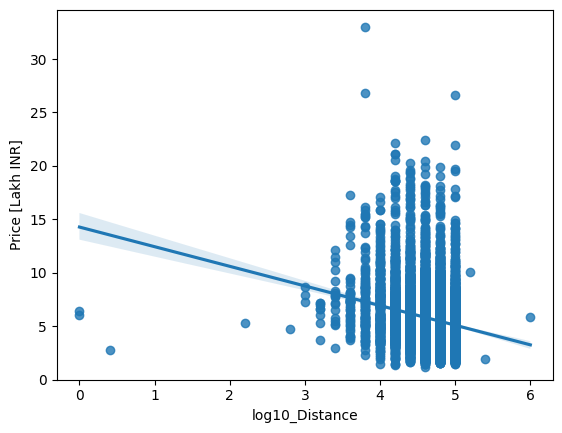

In [11]:
sns.regplot(x="log10_Distance", y="Price [Lakh INR]", data=car_data)
plt.ylim(0,)

In [12]:
pearson_coef, p_value = stats.pearsonr(car_data['log10_Distance'], car_data['Price [Lakh INR]'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P = ", p_value)  

The Pearson Correlation Coefficient is -0.21536473710288354  with a P-value of P =  9.768675163457685e-85


 The above cells shows us that log_10_distance/distance specifically does not have a leniar relationship with price as it is all scattered in one region only. The value of pearson correlation coefficient also indicate that they are not that much related and have a weak correlation.

<Axes: xlabel='log10_Distance', ylabel='Price [Lakh INR]'>

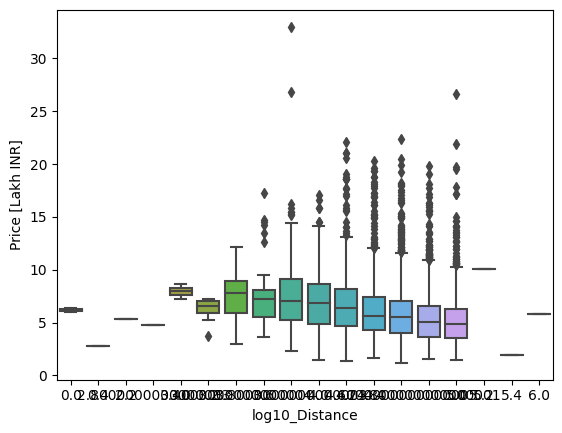

In [13]:
sns.boxplot(x="log10_Distance", y="Price [Lakh INR]", data=car_data)

Text(0.5, 1.0, 'distance bins')

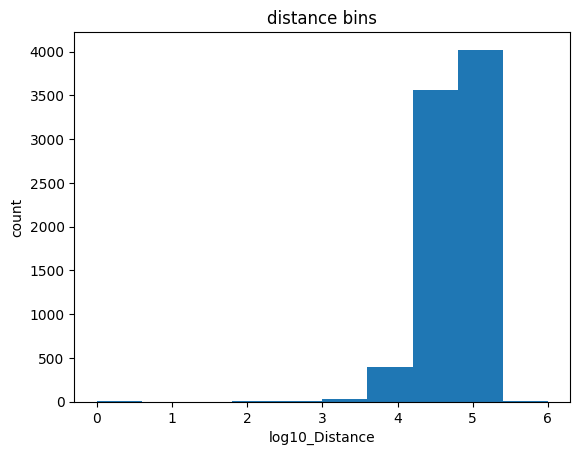

In [14]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(car_data["log10_Distance"])

# set x/y labels and plot title
plt.pyplot.xlabel("log10_Distance")
plt.pyplot.ylabel("count")
plt.pyplot.title("distance bins")

In [15]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8014 entries, 0 to 8013
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car Name          8014 non-null   object 
 1   Year              8014 non-null   object 
 2   Owner             8014 non-null   int64  
 3   Fuel              8014 non-null   object 
 4   Location          8014 non-null   object 
 5   Drive             8014 non-null   object 
 6   Type              8014 non-null   object 
 7   Price [Lakh INR]  8014 non-null   float64
 8   log10_Distance    8014 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 563.6+ KB


Text(0.5, 1.0, 'Year bins')

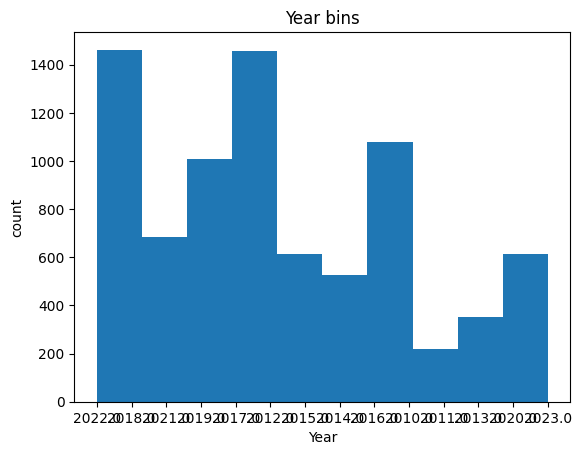

In [16]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(car_data["Year"])

# set x/y labels and plot title
plt.pyplot.xlabel("Year")
plt.pyplot.ylabel("count")
plt.pyplot.title("Year bins")


### Now we will make boxplots of different categorical variables against price, To check whether the categories have some effect on the car price and that they can be used in our model.

<Axes: xlabel='Type', ylabel='Price [Lakh INR]'>

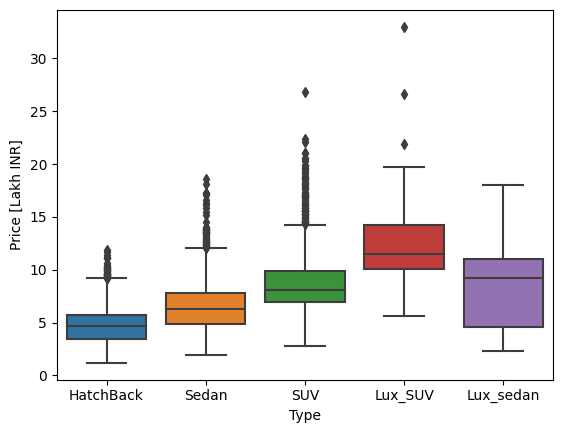

In [17]:
sns.boxplot(x="Type", y="Price [Lakh INR]", data=car_data)

<Axes: xlabel='Year', ylabel='Price [Lakh INR]'>

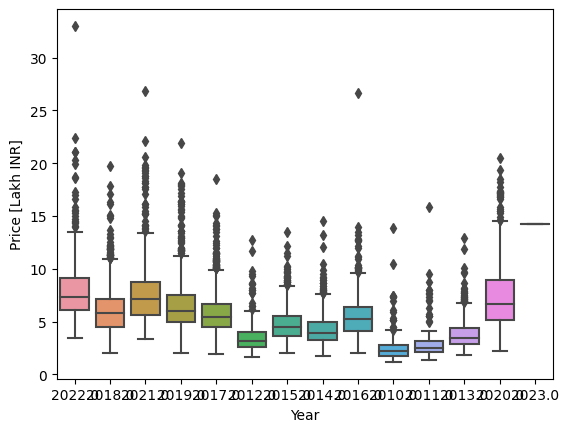

In [18]:
sns.boxplot(x="Year", y="Price [Lakh INR]", data=car_data)

<Axes: xlabel='Drive', ylabel='Price [Lakh INR]'>

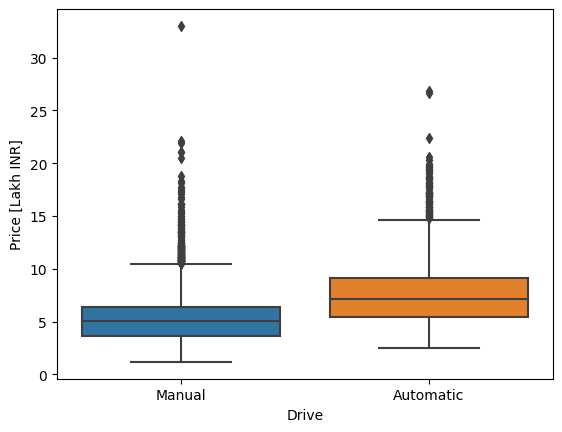

In [19]:
sns.boxplot(x="Drive", y="Price [Lakh INR]", data=car_data)

<Axes: xlabel='Fuel', ylabel='Price [Lakh INR]'>

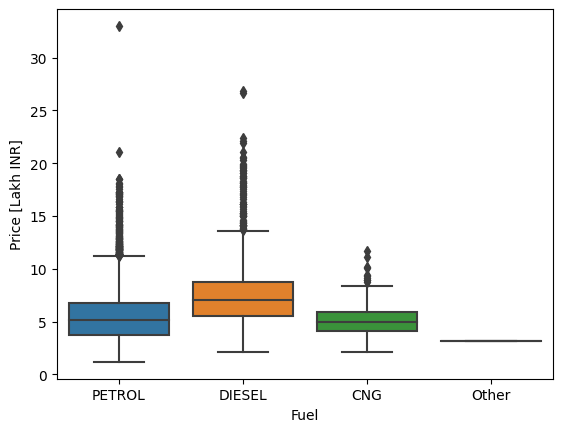

In [20]:
sns.boxplot(x="Fuel", y="Price [Lakh INR]", data=car_data)

<Axes: xlabel='Owner', ylabel='Price [Lakh INR]'>

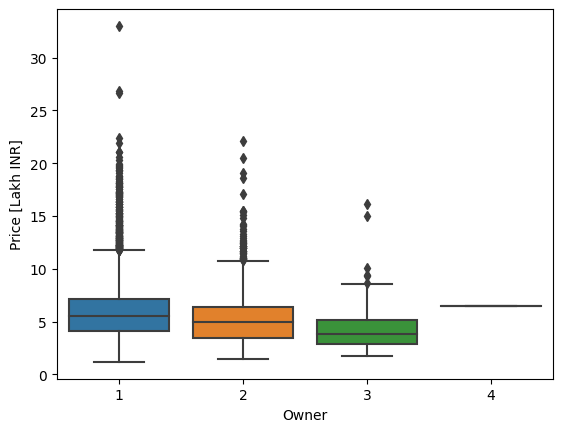

In [21]:
sns.boxplot(x="Owner", y="Price [Lakh INR]", data=car_data)

In [22]:
car_test = car_data[["Type","Drive","Price [Lakh INR]"]]
car_group = car_test.groupby(["Type","Drive"],as_index = False).mean()
car_group

,Type,Drive,Price [Lakh INR]
0,HatchBack,Automatic,5.676918
1,HatchBack,Manual,4.516089
2,Lux_SUV,Automatic,13.780629
3,Lux_SUV,Manual,11.449633
4,Lux_sedan,Automatic,10.834382
5,Lux_sedan,Manual,5.211917
6,SUV,Automatic,10.559628
7,SUV,Manual,8.028255
8,Sedan,Automatic,8.212865
9,Sedan,Manual,5.858791


In [23]:
car_pivot = car_group.pivot(index = "Drive",columns = "Type")
car_pivot

Price [Lakh INR]                                           
Type             HatchBack    Lux_SUV  Lux_sedan        SUV     Sedan
Drive                                                                
Automatic         5.676918  13.780629  10.834382  10.559628  8.212865
Manual            4.516089  11.449633   5.211917   8.028255  5.858791

<Axes: xlabel='None-Type', ylabel='Drive'>

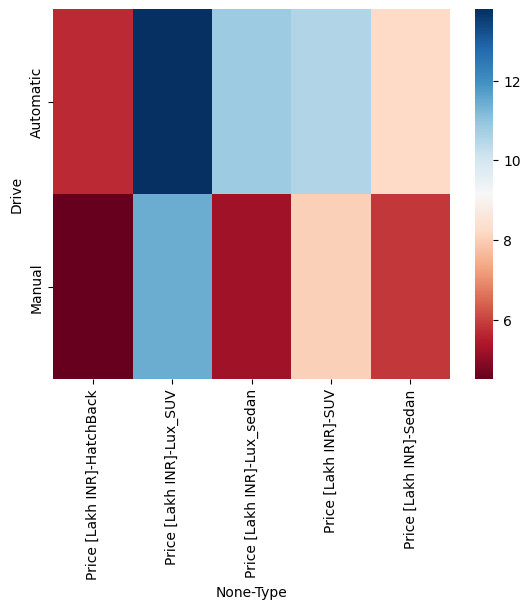

In [24]:
sns.heatmap(car_pivot , cmap = 'RdBu')

### ANNOVA
**ANOVA (Analysis of Variance)** is a statistical technique used to compare the means of two or more groups and determine whether there are significant differences among them. In our project, we applied ANOVA to analyze the impact of the categorical feature 'Drive' (e.g., Front-wheel drive, Rear-wheel drive) on the 'Price' of used cars. By calculating the F-value and p-value, we assess the statistical significance of 'Drive' in explaining the variation in 'Price', helping us understand if different drive types have a significant effect on the car's price.



In [25]:
grouped_test=car_data[['Type', 'Price [Lakh INR]']].groupby(['Type'])
grouped_test.head(2)

,Type,Price [Lakh INR]
0,HatchBack,5.14
1,Sedan,6.74
2,SUV,19.52
3,SUV,6.90
4,HatchBack,5.26
14,Sedan,5.03
51,Lux_SUV,21.92
68,Lux_SUV,12.22
318,Lux_sedan,11.22
325,Lux_sedan,8.60


In [26]:
grouped_test.get_group('HatchBack')['Price [Lakh INR]']

0       5.14
4       5.26
5       5.52
6       2.78
7       5.18
        ... 
7997    5.06
8000    7.42
8007    5.54
8009    2.92
8012    6.85
Name: Price [Lakh INR], Length: 5080, dtype: float64

In [27]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_test.get_group('HatchBack')['Price [Lakh INR]'], grouped_test.get_group('Sedan')['Price [Lakh INR]'], grouped_test.get_group('SUV')['Price [Lakh INR]'], grouped_test.get_group('Lux_SUV')['Price [Lakh INR]'], grouped_test.get_group('Lux_sedan')['Price [Lakh INR]'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)    

ANOVA results: F= 1205.104817434834 , P = 0.0


In [28]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8014 entries, 0 to 8013
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car Name          8014 non-null   object 
 1   Year              8014 non-null   object 
 2   Owner             8014 non-null   int64  
 3   Fuel              8014 non-null   object 
 4   Location          8014 non-null   object 
 5   Drive             8014 non-null   object 
 6   Type              8014 non-null   object 
 7   Price [Lakh INR]  8014 non-null   float64
 8   log10_Distance    8014 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 563.6+ KB


In [29]:
grouped_test2=car_data[['Drive', 'Price [Lakh INR]']].groupby(['Drive'])
grouped_test2.head(2)

,Drive,Price [Lakh INR]
0,Manual,5.14
1,Manual,6.74
2,Automatic,19.52
7,Automatic,5.18


In [30]:
grouped_test2.get_group('Automatic')['Price [Lakh INR]']

2       19.5200
7        5.1800
9        7.1035
10       5.4800
11       4.8100
         ...   
7999     6.2700
8004     7.2100
8006    12.8500
8008     8.2100
8012     6.8500
Name: Price [Lakh INR], Length: 1559, dtype: float64

In [31]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_test2.get_group('Automatic')['Price [Lakh INR]'], grouped_test2.get_group('Manual')['Price [Lakh INR]'])
print( "ANOVA results: F=", f_val, ", P =", p_val)    

ANOVA results: F= 1213.5089806542517 , P = 1.059485296868022e-247


In [32]:
grouped_test3=car_data[['Owner', 'Price [Lakh INR]']].groupby(['Owner'])

In [33]:
car_data['Owner'].value_counts()

Owner
1    5811
2    2001
3     201
4       1
Name: count, dtype: int64

In [34]:
grouped_test3.get_group(1)['Price [Lakh INR]']

0        5.14
1        6.74
2       19.52
3        6.90
4        5.26
        ...  
8003     6.12
8004     7.21
8006    12.85
8009     2.92
8012     6.85
Name: Price [Lakh INR], Length: 5811, dtype: float64

In [35]:
f_val, p_val = stats.f_oneway(grouped_test3.get_group(1)['Price [Lakh INR]'], grouped_test3.get_group(2)['Price [Lakh INR]'], grouped_test3.get_group(3)['Price [Lakh INR]'], grouped_test3.get_group(4)['Price [Lakh INR]'])
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 61.98010626050917 , P = 1.3154814125600983e-39


In [36]:
car_data['Fuel'].value_counts()

Fuel
PETROL    6412
DIESEL    1066
CNG        535
Other        1
Name: count, dtype: int64

In [37]:
grouped_test4=car_data[['Fuel', 'Price [Lakh INR]']].groupby(['Fuel'])
f_val, p_val = stats.f_oneway(grouped_test4.get_group('PETROL')['Price [Lakh INR]'], grouped_test4.get_group('DIESEL')['Price [Lakh INR]'], grouped_test4.get_group('CNG')['Price [Lakh INR]'])
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 377.6270885141028 , P = 1.8894994796198206e-157


# 4. Machine Learning

In this section, we select the CatBoost Regressor as our machine learning model based on our exploratory data analysis (EDA) findings. The EDA revealed that the 'Price' of used cars is highly dependent on categorical variables, as indicated by the large F-value and small p-value obtained from ANOVA tests.

**CatBoost Regressor** is a powerful gradient boosting algorithm that is well-suited for handling categorical features. It can automatically handle the encoding of categorical variables, which eliminates the need for manual encoding techniques. Additionally, CatBoost Regressor is resilient to overfitting, thanks to its built-in regularization techniques and robust handling of high-cardinality categorical data.

By leveraging CatBoost Regressor, we aim to build a predictive model that effectively incorporates the categorical information and accurately predicts the 'Price' of used cars. The model's ability to capture complex interactions between features makes it a compelling choice for our machine learning project.


In [38]:
# initialize data
y = car_data[main_label].values.reshape(-1,)
X = car_data.drop([main_label], axis=1)
cat_cols = car_data.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4007, 8), (4007, 8), (4007,), (4007,))

In [39]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=5,
                          verbose=0,
                          learning_rate=0.02, 
                          loss_function='RMSE')
# train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)


r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)


print(f"RMSE score for train {round(r2_train,2)} Lakh INR, and for test {round(r2_test,2)} Lakh INR")
print(f"r2 score for train {round(r2_train,2)} , and for test {round(r2_test,2)} ")

RMSE score for train 0.83 Lakh INR, and for test 0.79 Lakh INR
r2 score for train 0.83 , and for test 0.79 


In [40]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,2)} Lakh INR, and for test {round(rmse_bs_test,2)} Lakh INR")

RMSE baseline score for train 2.72 Lakh INR, and for test 2.58 Lakh INR


# 5. SHAP (SHapley Additive exPlanations)

**SHAP (SHapley Additive exPlanations)** is a powerful and interpretable framework for explaining the predictions of machine learning models. It is based on game theory concepts and provides a unified approach to explain the contribution of each feature to a model's prediction for a particular instance.

### Summary Plot
I used the summary plot generated using SHAP to gain a holistic understanding of the model's behavior and identify the most influential features in predicting used car prices. The ranked feature importance helps me focus on the critical variables that significantly impact the model's predictions.

### Layered Violin Plot
By using the layered violin plot, I aimed to visualize the distribution of SHAP values for each feature, grouped by feature values. This plot helps me understand how different feature values influence individual predictions, identify any patterns or correlations, and detect potential interactions between features.

### Dependence Plot
The dependence plot was utilized to explore the relationship between the target feature (e.g., 'log10_Distance') and its corresponding SHAP values. This plot allows me to observe how changes in a specific feature value impact the model's predictions, providing valuable insights into the feature's effect on used car prices.

Overall, these SHAP visualizations aid in interpreting the complex behavior of the CatBoost Regressor model, helping me gain transparency into its decision-making process and ensuring its reliability and trustworthiness in predicting used car prices.


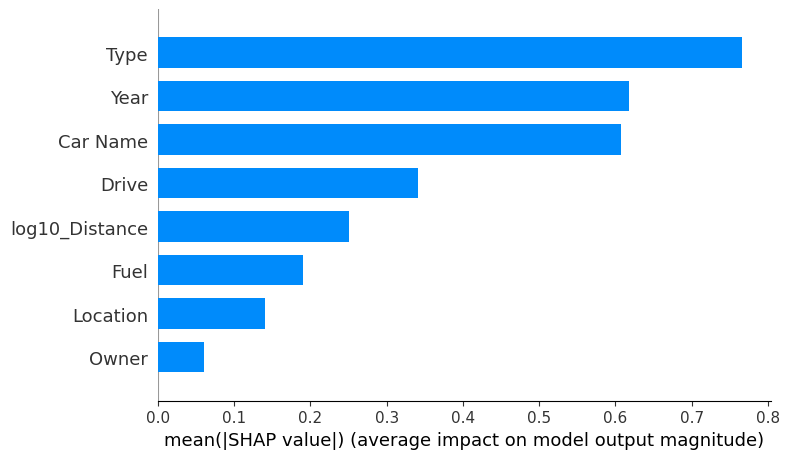

In [41]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test,plot_type='bar', color_bar= False)

In [42]:
expected_values = ex.expected_value
print(f"Average predicted price is {round(expected_values,1)} Lakh INR")
print(f"Average actual price is {round(np.mean(y_test),1)} Lakh INR")

Average predicted price is 5.8 Lakh INR
Average actual price is 5.7 Lakh INR


not enough data in bin #1 for feature log10_Distance, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #2 for feature log10_Distance, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #14 for feature log10_Distance, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #15 for feature log10_Distance, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #16 for feature log10_Distance, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #13 for feature Year, so it'll be ignored. Try increasing the number of records to plot.


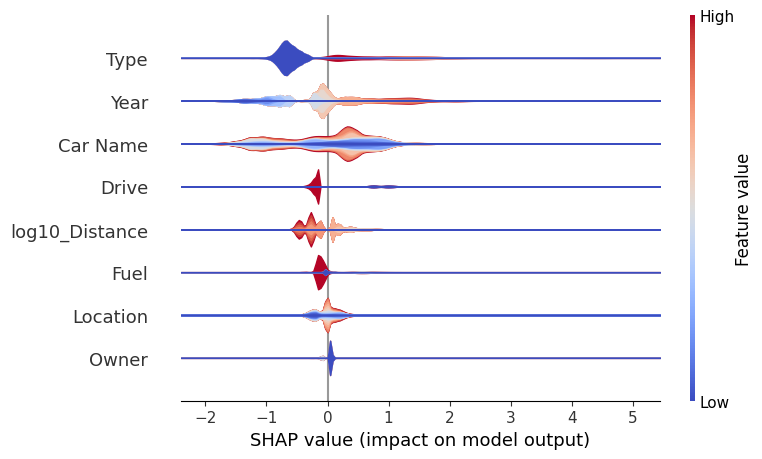

In [44]:
# Layered Violin Plot
shap.summary_plot(shap_values, X_test, plot_type='layered_violin')



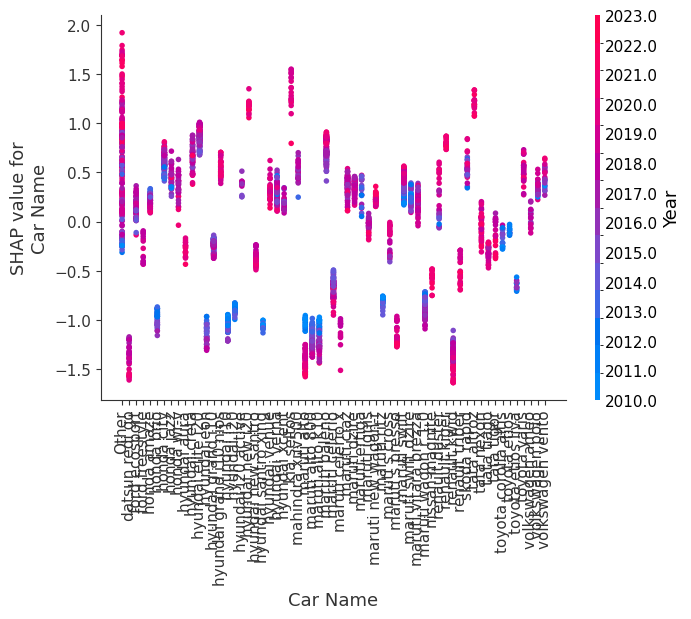

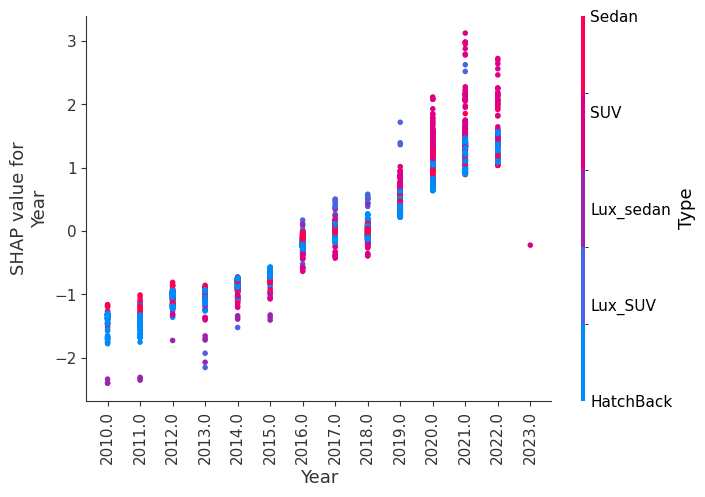

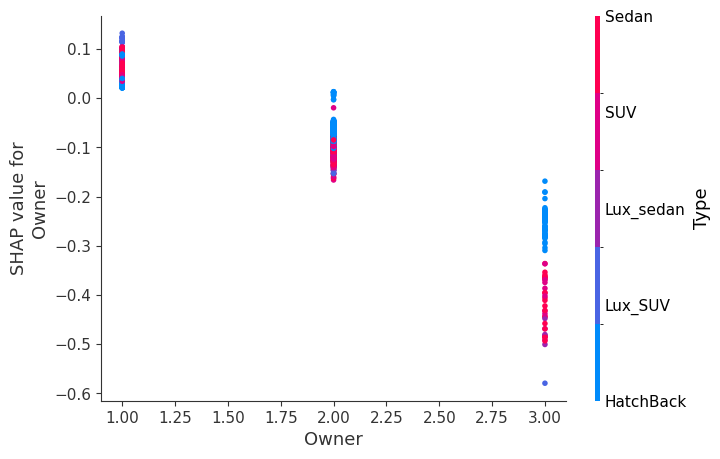

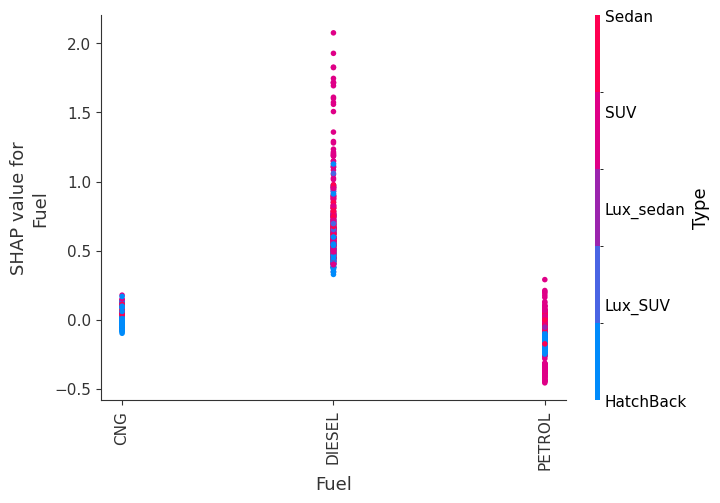

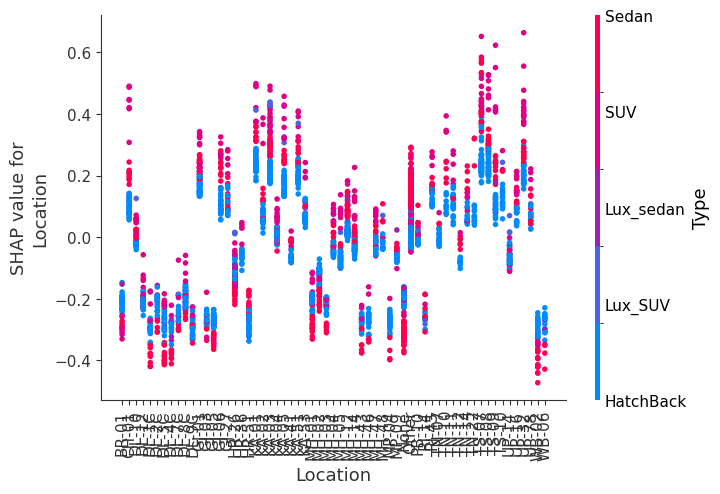

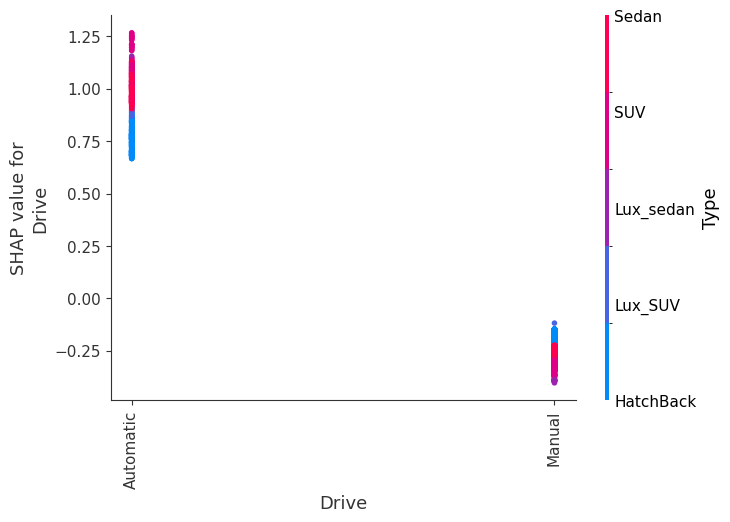

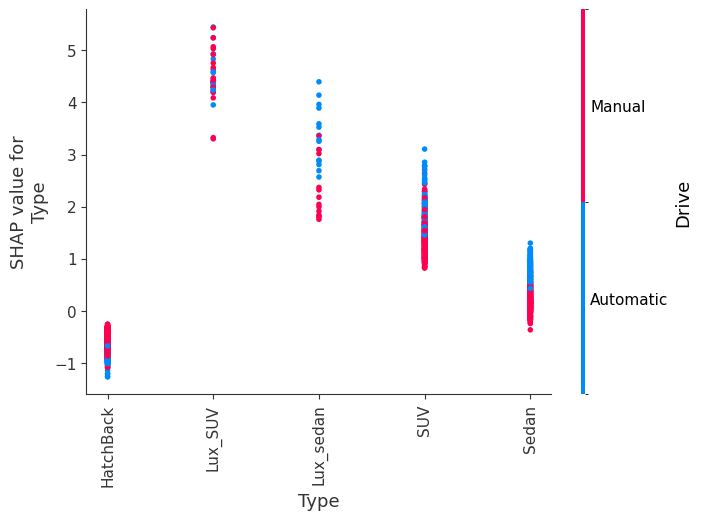

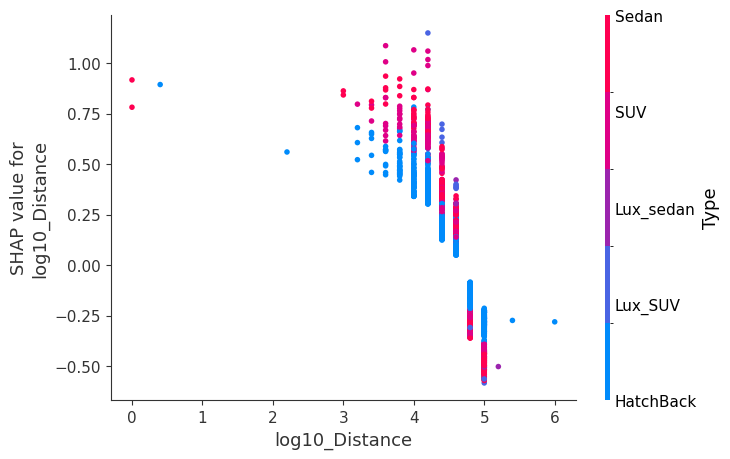

In [46]:
for column in car_data.columns:
    if column != 'Price [Lakh INR]':
        shap.dependence_plot(column, shap_values, X_test)
        


In [47]:
shap_values

array([[ 0.87363615,  1.40686746,  0.03347261, ..., -0.21798046,
        -0.69029245,  0.2212442 ],
       [ 0.05592789, -0.57632912,  0.03701986, ..., -0.30872268,
         1.02302172, -0.42638978],
       [-0.35146038,  0.25123251,  0.03530435, ..., -0.17171083,
        -0.66566621, -0.16351783],
       ...,
       [-1.16813461, -0.60540357,  0.03534071, ..., -0.15571119,
        -0.72558333,  0.06742334],
       [-0.94680909, -0.96856808, -0.0867772 , ..., -0.15593538,
        -0.67466586, -0.22755241],
       [ 0.16802756,  0.73305611, -0.07642686, ..., -0.19859058,
        -0.76567576,  0.09439247]])

In [52]:
shap.plots.force(ex.expected_value,shap_values[0:10])

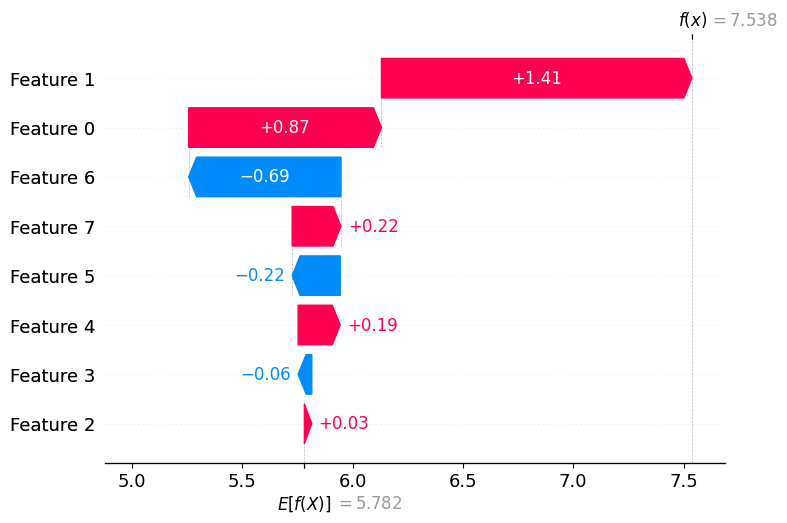

In [57]:
shap.plots._waterfall.waterfall_legacy(ex.expected_value, shap_values[0])

In [77]:
# Save the CatBoost model to a file using Pickle
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)